In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## **Abstract**

Ensuring worldwide food safety and security is a major target by the UN and WHO, especially in recent years due to the Covid-19 pandemic and the Ukraine war. In this project, we used a multiple linear regression model to predict the **prevalence of undernourishment** in individual countries based on the country's **socio-economic indicators** in 2020. Our dataset consisted of **133 examples** with 94 examples in the training set and 39 examples in the test set. Through visualization and analysis of multicollinearity matrices, we selected 4 indicators as our final independent variables: net FDI flow, proportion of access to electricity, fertility rate, and corruption perception index. Our best model achieved an **adjusted R<sup>2</sup> score of 0.74**.

## **Background**

### Problem statement 
How might we predict **food insecurity** in a country based on the **socio-economic conditions** of that country in **2020**?

### **Datasets**

**Independent variables**

We considered 14 socio-economic indicators as potential independent variables. The following criteria were used for selection:
1. Reflects a social or economic aspect of a country
2. Isn't an "aggregrate" index such as the Human Development Index (HDI). This is to reduce future multicollinearity as much as possible.

We implemented [preliminary cleaning](https://github.com/Sean2309/2D_DDW_LinReg/tree/main/Code/Processing) on the datasets (2016 - 2020) corresponding to each indicator by replacing null values with the mean. In the process, we elimitated 3 indicators that have more than one-third null values.

The selected **11 socio-economic indicators** were then joined together based on a set of standardized country code. 

1. Access_To_Electricity (%) <br>
*Percentage of population with access to electricity. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

2. CPI_Food <br>
*Consumer Price Indices of Food is the change over time in the general level of prices of food and non-alcoholic beverage items included in households' expenditure. Base year is 2015 (100). Monthly data, with the annual value stored in December of every year. Sourced from [FAO](https://www.fao.org/faostat/en/#data/CP).*

3. Corruption_Perception_Index <br>
*How corrupt the public sectors are perceived to be. Scale of 0 to 100, where 0 is highly corrupt and 100 is very clean. Annual data. Sourced from [Transparency Intl.](https://www.transparency.org/en/cpi/2020).*

4. Fertility_Rate (births per woman) <br>
*Number of children that would be born to a woman if she were to live to the end of her childbearing years and bear children in accordance with age-specific fertility rates of the specified year. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

5. Immunization_Measles (%) <br>
*Percentage of children ages 12 - 23 months who received the measles vaccination. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

6. Infant_Mortality_Rate <br>
*Probability per 1,000 that a newborn baby will die before reaching age five. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

7. Labor_Force_Gender_Ratio (%) <br>
*Ratio of female to male labor force participation rate. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

8. Life_Expectancy (years) <br>
*Number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life. Annual data. Sourced from [UNDP](https://hdr.undp.org/data-center/documentation-and-downloads).*

9. Net_FDI_Flow (millions) <br>
*Total value of inward direct investment made by non-resident investors in the reporting economy minus total value of outward direct investment made by the residents of the reporting economy to external economies. Annual data. Sourced from [FAO](https://www.fao.org/faostat/en/#data/FDI).*

10. Mean_Years_Of_Schooling (years) <br>
*Average number of years of schooling that population ages 25 and older underwent. Annual data. Sourced from [UNDP](https://hdr.undp.org/data-center/documentation-and-downloads).*

11. Unemployment (%) <br>
*Percentage of the labor force that is without work but available for and seeking employment. Annual data. Sourced from [World Bank](https://databank.worldbank.org/source/world-development-indicators/preview/on).*

**Dependent variable**

We selected **1 food security indicator** as our dependent variable that indicates the level of sufficiency and ease of access to nutritious food in a country.

1. Prevalence_of_undernourishment (%) <br>
*Probability that a randomly selected individual from the population consumes an amount of calories that is insufficient to cover his/her energy requirement for an active and healthy life. Traditional FAO hunger indicator. Annual data. Sourced from [FAO](https://www.fao.org/faostat/en/#data/FS).*

Shown below are samples of our **Dependent Variable** and **1 of our Independent Variables** in their unprocessed form

In [125]:
df_original_prevalence = pd.read_csv("..\..\Datasets\Original\PrevalenceofUndernourishment_2016_2020_Percent_byCountry.csv")
df_original_corruption_idx = pd.read_csv("..\..\Datasets\Original\Corruption_Perception_Index.csv")

In [126]:
df_original_prevalence.head(5)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (SDG),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,SDGB,SDG Indicators,4,Afghanistan,6121,Value,SN_ITK_DEFC,2.1.1 Prevalence of undernourishment (%),2016,2016,%,22.2,NaN,NaN,"Global | FAO, Statistics Division | Estimated ..."
1,SDGB,SDG Indicators,4,Afghanistan,6121,Value,SN_ITK_DEFC,2.1.1 Prevalence of undernourishment (%),2017,2017,%,23,NaN,NaN,"Global | FAO, Statistics Division | Estimated ..."
2,SDGB,SDG Indicators,4,Afghanistan,6121,Value,SN_ITK_DEFC,2.1.1 Prevalence of undernourishment (%),2018,2018,%,24,NaN,NaN,"Global | FAO, Statistics Division | Estimated ..."
3,SDGB,SDG Indicators,4,Afghanistan,6121,Value,SN_ITK_DEFC,2.1.1 Prevalence of undernourishment (%),2019,2019,%,26.9,NaN,NaN,"Global | FAO, Statistics Division | Estimated ..."
4,SDGB,SDG Indicators,4,Afghanistan,6121,Value,SN_ITK_DEFC,2.1.1 Prevalence of undernourishment (%),2020,2020,%,29.8,NaN,NaN,"Global | FAO, Statistics Division | Estimates ..."


In [127]:
df_original_corruption_idx.head(5)

,Country,ISO3,Region,CPI score 2020,Rank 2020,Sources 2020,Standard error 2020,CPI score 2019,Rank 2019,Sources 2019,...,Rank 2018,Sources 2018,Standard error 2018,CPI score 2017,Rank 2017,Sources 2017,Standard error 2017,CPI score 2016,Sources 2016,Standard error 2016
0,Denmark,DNK,WE/EU,88,1,8,1.78,87,1,8,...,1,8,2.63,88,2,8,2.75,90.0,7.0,2.46
1,New Zealand,NZL,AP,88,1,8,1.48,87,1,8,...,2,8,2.44,89,1,8,2.40,90.0,7.0,2.56
2,Finland,FIN,WE/EU,85,3,8,1.75,86,3,8,...,3,8,2.74,85,3,8,2.84,89.0,7.0,1.46
3,Singapore,SGP,AP,85,3,9,1.20,85,4,9,...,3,9,1.98,84,6,9,2.26,84.0,8.0,2.35
4,Sweden,SWE,WE/EU,85,3,8,1.30,85,4,8,...,3,8,2.02,84,6,8,2.27,88.0,7.0,1.33


## **Exploratory Data Analysis (EDA)**
*EDA is used to gain initial insights into the datasets* <br><br>

**Defining Important Plotting Functions:** <br> <br>
These functions will be used later for the *generation of plots*

In [128]:
## Plot types for each type of analysis
PLOT_TYPES_UNI = ["Hist", "KDE"]
PLOT_TYPES_BI = ["Bar", "Violin", "Scatter"]
YEAR_L = [2016,2017,2018,2019,2020]

## Making targeted directories for plots to be saved in
cwd = os.getcwd()
UNIVARIATE = os.path.join(cwd,"Graphs/Graphs_EDA/Univariate_Analysis")
BIVARIATE = os.path.join(cwd,"Graphs/Graphs_EDA/Bivariate_Analysis")
if not os.path.isdir(UNIVARIATE):
    os.makedirs(UNIVARIATE)
if not os.path.isdir(BIVARIATE):
    os.makedirs(BIVARIATE)

# PLOTS_TO_FUNC: Dictionary of seaborn plotting functions
PLOTS_TO_FUNC = {
    "Hist": sns.histplot,
    "KDE": sns.kdeplot,
    "Ecdf": sns.ecdfplot,
    "Bar": sns.barplot,
    "Scatter": sns.scatterplot,
    "Violin": sns.violinplot,
    "Line": sns.lineplot
}

# rotate_axis: Dynamic Rotation of the x tick labels of each plot based on a threshold (5)
def rotate_axis(
    fig,
) -> bool:
    """
    Dynamic rotation of x axis labels
    """
    num_labels = len(fig.get_xticklabels())
    if num_labels >= 5:
        return True
    else:
        return False

# save_fig: Saving the generated plot into a destination folder
def save_fig(
    fig,
    dest_path,
    file_name
):
    locs, labels = plt.xticks()
    if rotate_axis(fig):
        plt.setp(labels,rotation=45, horizontalalignment="right")
    else:
        plt.setp(labels, horizontalalignment="right")

    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches="tight")
    plt.close()

# auto generation of plots functions
def plot_transposed_df_univariate(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    x: str = "Prevalence_of_undernourishment",   
):  
    dest_path = os.path.join(UNIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.makedirs(dest_path)
    for item in range(len(cols_dict[key])):
        for plot_type in PLOT_TYPES_UNI:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in, x=f"{x}_{YEAR_L[item]}", hue=f"{cols_dict[key][item]}_Cat")
            file_name = f"{plot_type}_plot_{x}_hue_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)

def plot_transposed_df_bivariate_hue(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    hue_l = str,
    x: str = "Prevalence_of_undernourishment",
):  
    dest_path = os.path.join(BIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.makedirs(dest_path)
    for item in range(len(cols_dict[key])):
        for plot_type in PLOT_TYPES_BI:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in,x=f"{cols_dict[key][item]}_Cat", y=f"{x}_{YEAR_L[item]}", hue=f"{cols_dict[hue_l][item]}_Cat")
            file_name = f"{plot_type}_plot_y_{x}_x_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)

def plot_transposed_df_bivariate_no_hue(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    x: str = "Prevalence_of_undernourishment",
):  
    dest_path = os.path.join(BIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.makedirs(dest_path)
    for item in range(len(cols_dict[key])):
        for plot_type in PLOT_TYPES_BI:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in,x=f"{cols_dict[key][item]}_Cat", y=f"{x}_{YEAR_L[item]}")
            file_name = f"{plot_type}_plot_y_{x}_x_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)


### **Initial Insights**<br>
We generated a few plots for initial insights:
1. Heat Map => *Relational analysis* between each column
2. Histogram + KDE => *Univariate analysis* to see the distributions of selected variables

In [5]:
df_combined_untransposed = pd.read_csv("..\..\Datasets\Processed\All_Processed.csv") 
df_combined_untransposed.head(5)

,ISO3_Code,Country_Name,M49_Code,Year,Life_Expectancy,Mean_Years_Of_Schooling,CPI_Food,Net_FDI,Infant_Mortality_Rate,Unemployment,Access_To_Electricity,Fertility_Rate,Immunization_Measles,Labor_Force_Gender_Ratio,Corruption_Perception_Index,Prevalence_of_undernourishment
0,AFG,Afghanistan,4.0,2016,63.1361,2.463660,108.916832,78.810000,67.5,11.158,97.699997,4.800,64.0,27.103841,15.0,22.2
1,AGO,Angola,24.0,2016,61.0923,5.417391,154.136774,-452.522619,84.1,7.412,41.813129,5.686,45.0,93.805355,18.0,15.4
2,ALB,Albania,8.0,2016,78.8602,10.727528,104.588667,1036.471408,9.4,15.420,99.889999,1.659,96.0,76.660488,39.0,4.7
3,ARE,United Arab Emirates,784.0,2016,79.3347,10.842620,100.998062,-6106.627000,7.4,1.640,100.000000,1.491,99.0,54.934187,66.0,6.3
4,ARG,Argentina,32.0,2016,76.3077,10.928190,119.206012,1473.633407,10.9,8.111,99.849579,2.288,90.0,67.066406,36.0,2.6


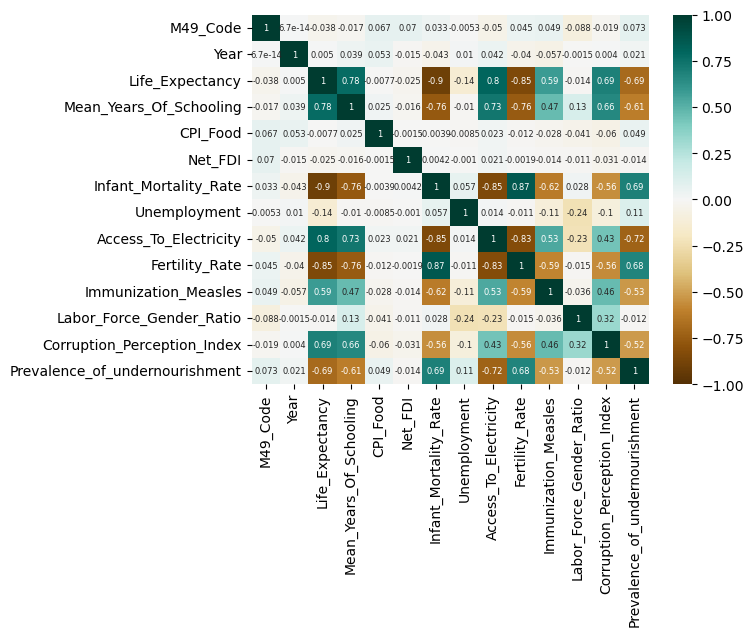

In [12]:
corr = df_combined_untransposed.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="BrBG", annot_kws={"fontsize":6})
plt.show()

<AxesSubplot:xlabel='Prevalence_of_undernourishment', ylabel='Count'>

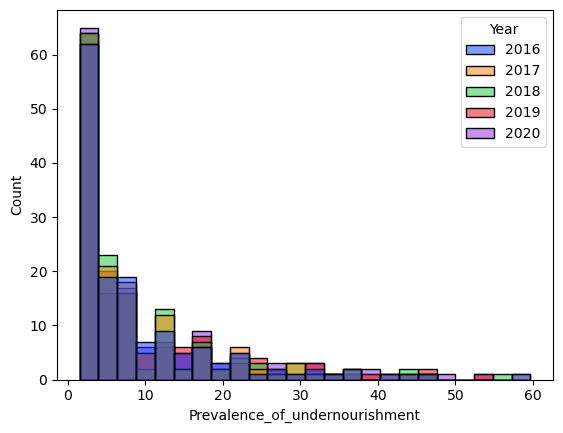

In [22]:
sns.histplot(data=df_combined_untransposed, x="Prevalence_of_undernourishment", hue="Year", palette="bright")

**Insights**
1. Heat Map:<br>
Focusing on the last column where each independent variable is mapped to the dependent variable (Prevalence of Undernourishment) <br>
- *Green highlighted cells* imply a **positive correlation** between Prevalence of Undernourishment and the respective independent variable
- *Brown highlighted cells* imply a **negative correlation** between Prevalence of Undernourishment and the respective independent variable
- The darker the colour, the greater the correlation is present between the 2 variables
2. Histogram:<br>
- Throughout the 5 year period, the distribution of the Prevalence of Undernourishment remains right-skewed<br>
=>Majority of the countries in our datasets are not experiencing high levels of undernourishment.

### **Data Processing** <br>
The only categorical variables present in the dataset are *Country_Name*, *M49_Code* & *ISO3_Code*. <br><br>
These columns are **not suitable** for plots since each of them is only mapped to 1 row of data. Thus, we decided to do data processing to transform the independent & dependent variables *numerical columns* into *categorical columns*<br><br>

Transformation:
- Setting **boundary intervals** based on the max and min values of each column
- **Cutting** the respective column and assigning names to each category

In [129]:
# df_combined_transposed: Combined DF after Preliminary Cleaning
df_combined_transposed = pd.read_csv("..\..\Datasets\Processed\All_DF_Processed.csv")
df_combined_transposed.head(5)

,ISO3_Code,Country_Name,M49_Code,Life_Expectancy_2016,Life_Expectancy_2017,Life_Expectancy_2018,Life_Expectancy_2019,Life_Expectancy_2020,Mean_Years_Of_Schooling_2016,Mean_Years_Of_Schooling_2017,...,Corruption_Perception_Index_2020,Corruption_Perception_Index_2019,Corruption_Perception_Index_2018,Corruption_Perception_Index_2017,Corruption_Perception_Index_2016,Prevalence_of_undernourishment_2016,Prevalence_of_undernourishment_2017,Prevalence_of_undernourishment_2018,Prevalence_of_undernourishment_2019,Prevalence_of_undernourishment_2020
0,AFG,Afghanistan,4.0,63.1361,63.0160,63.0810,63.5645,62.5751,2.463660,2.561425,...,19.0,16.0,16.0,15.0,15.0,22.2,23.0,24.0,26.9,29.8
1,AGO,Angola,24.0,61.0923,61.6798,62.1438,62.4484,62.2612,5.417391,5.417391,...,27.0,26.0,19.0,19.0,18.0,15.4,15.4,15.7,17.9,20.8
2,ALB,Albania,8.0,78.8602,79.0473,79.1838,79.2825,76.9893,10.727528,10.910692,...,36.0,35.0,36.0,38.0,39.0,4.7,4.7,4.6,4.3,3.9
3,ARE,United Arab Emirates,784.0,79.3347,79.5036,79.6274,79.7262,78.9457,10.842620,12.055400,...,71.0,71.0,70.0,71.0,66.0,6.3,6.4,6.2,6.0,5.6
4,ARG,Argentina,32.0,76.3077,76.8330,76.9994,77.2845,75.8921,10.928190,11.016445,...,42.0,45.0,40.0,39.0,36.0,2.6,3.1,3.4,3.5,3.7


In [47]:
# Cols Dict: Dictionary of all the columns in the Processed dataset
cols_dict = {
    "Prevalence_of_undernourishment" : ["Prevalence_of_undernourishment_2016", "Prevalence_of_undernourishment_2017", "Prevalence_of_undernourishment_2018","Prevalence_of_undernourishment_2019","Prevalence_of_undernourishment_2020"],
    "Life_Expectancy" : ['Life_Expectancy_2016','Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019','Life_Expectancy_2020'],
    "Mean_Years_Of_Schooling": ['Mean_Years_Of_Schooling_2016','Mean_Years_Of_Schooling_2017', 'Mean_Years_Of_Schooling_2018','Mean_Years_Of_Schooling_2019', 'Mean_Years_Of_Schooling_2020'],
    "CPI_Food": ['CPI_Food_2016', 'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019', 'CPI_Food_2020'],
    "Net_FDI": ['Net_FDI_2016', 'Net_FDI_2017','Net_FDI_2018', 'Net_FDI_2019', 'Net_FDI_2020'],
    "Infant_Mortality_Rate": ["Infant_Mortality_Rate_2016","Infant_Mortality_Rate_2017","Infant_Mortality_Rate_2018","Infant_Mortality_Rate_2019","Infant_Mortality_Rate_2020"],
    "Unemployment": [ 'Unemployment_2016', 'Unemployment_2017', 'Unemployment_2018','Unemployment_2019', 'Unemployment_2020'],
    "Access_To_Electricity": ['Access_To_Electricity_2016', 'Access_To_Electricity_2017', 'Access_To_Electricity_2018','Access_To_Electricity_2019', 'Access_To_Electricity_2020',],
    "Fertility_Rate": ["Fertility_Rate_2016","Fertility_Rate_2017","Fertility_Rate_2018","Fertility_Rate_2019","Fertility_Rate_2020"],
    "Immunization_Measles": ["Immunization_Measles_2016","Immunization_Measles_2017","Immunization_Measles_2018","Immunization_Measles_2019","Immunization_Measles_2020"],
    "Labor_Force_Gender_Ratio": ["Labor_Force_Gender_Ratio_2016","Labor_Force_Gender_Ratio_2017","Labor_Force_Gender_Ratio_2018","Labor_Force_Gender_Ratio_2019","Labor_Force_Gender_Ratio_2020"],
    "Corruption_Perception_Index": ["Corruption_Perception_Index_2016", 'Corruption_Perception_Index_2017', 'Corruption_Perception_Index_2018','Corruption_Perception_Index_2019','Corruption_Perception_Index_2020']
}

## Creating Cat Cols
def create_cat_cols(
    df_in : pd.DataFrame,
    cols_dict: dict,
    key: str,
    boundary_intervals_values: list,
    boundary_intervals_names: list
):  
    for item in range(len(cols_dict[key])):
        df_in[f"{cols_dict[key][item]}_Cat"] = pd.cut(df_in[cols_dict[key][item]], bins=boundary_intervals_values, labels=boundary_intervals_names)
    return df_in

# Sample: Transforming Dependent Variable (Prevalence of Undernourishment)
df_combined_transposed = create_cat_cols(df_in=df_combined_transposed, cols_dict=cols_dict, key="Prevalence_of_undernourishment", boundary_intervals_values=[0,20,40,60,80,100], boundary_intervals_names=["0-20", "20-40","40-60","60-80","80-100"])
df_combined_transposed.head(5)

,ISO3_Code,Country_Name,M49_Code,Life_Expectancy_2016,Life_Expectancy_2017,Life_Expectancy_2018,Life_Expectancy_2019,Life_Expectancy_2020,Mean_Years_Of_Schooling_2016,Mean_Years_Of_Schooling_2017,...,Prevalence_of_undernourishment_2016,Prevalence_of_undernourishment_2017,Prevalence_of_undernourishment_2018,Prevalence_of_undernourishment_2019,Prevalence_of_undernourishment_2020,Prevalence_of_undernourishment_2016_Cat,Prevalence_of_undernourishment_2017_Cat,Prevalence_of_undernourishment_2018_Cat,Prevalence_of_undernourishment_2019_Cat,Prevalence_of_undernourishment_2020_Cat
0,AFG,Afghanistan,4.0,63.1361,63.0160,63.0810,63.5645,62.5751,2.463660,2.561425,...,22.2,23.0,24.0,26.9,29.8,20-40,20-40,20-40,20-40,20-40
1,AGO,Angola,24.0,61.0923,61.6798,62.1438,62.4484,62.2612,5.417391,5.417391,...,15.4,15.4,15.7,17.9,20.8,0-20,0-20,0-20,0-20,20-40
2,ALB,Albania,8.0,78.8602,79.0473,79.1838,79.2825,76.9893,10.727528,10.910692,...,4.7,4.7,4.6,4.3,3.9,0-20,0-20,0-20,0-20,0-20
3,ARE,United Arab Emirates,784.0,79.3347,79.5036,79.6274,79.7262,78.9457,10.842620,12.055400,...,6.3,6.4,6.2,6.0,5.6,0-20,0-20,0-20,0-20,0-20
4,ARG,Argentina,32.0,76.3077,76.8330,76.9994,77.2845,75.8921,10.928190,11.016445,...,2.6,3.1,3.4,3.5,3.7,0-20,0-20,0-20,0-20,0-20


With all the columns transformed, we could now plot new graphs:
1. *Univariate* plots with hues
2. *Bivariate* plots <br>
These plots will be generated and saved in a specified dest folder locally, which can be then opened for further analysis 

In [50]:
# Reading the df with generated cateogorical columns
df_combined_transposed_cat_cols = pd.read_csv("..\..\Datasets\Processed\All_DF_Processed_with_Cat_Cols.csv")
df_combined_transposed_cat_cols.drop("Unnamed: 0", axis=1, inplace=True)
df_combined_transposed_cat_cols.head(5)

,ISO3_Code,Country_Name,M49_Code,Life_Expectancy_2016,Life_Expectancy_2017,Life_Expectancy_2018,Life_Expectancy_2019,Life_Expectancy_2020,Mean_Years_Of_Schooling_2016,Mean_Years_Of_Schooling_2017,...,Labor_Force_Gender_Ratio_2016_Cat,Labor_Force_Gender_Ratio_2017_Cat,Labor_Force_Gender_Ratio_2018_Cat,Labor_Force_Gender_Ratio_2019_Cat,Labor_Force_Gender_Ratio_2020_Cat,Corruption_Perception_Index_2016_Cat,Corruption_Perception_Index_2017_Cat,Corruption_Perception_Index_2018_Cat,Corruption_Perception_Index_2019_Cat,Corruption_Perception_Index_2020_Cat
0,AFG,Afghanistan,4.0,63.1361,63.0160,63.0810,63.5645,62.5751,2.463660,2.561425,...,20-40,20-40,20-40,20-40,20-40,0-20,0-20,0-20,0-20,0-20
1,AGO,Angola,24.0,61.0923,61.6798,62.1438,62.4484,62.2612,5.417391,5.417391,...,80-100,80-100,80-100,80-100,80-100,0-20,0-20,0-20,20-40,20-40
2,ALB,Albania,8.0,78.8602,79.0473,79.1838,79.2825,76.9893,10.727528,10.910692,...,60-80,60-80,60-80,60-80,60-80,20-40,20-40,20-40,20-40,20-40
3,ARE,United Arab Emirates,784.0,79.3347,79.5036,79.6274,79.7262,78.9457,10.842620,12.055400,...,40-60,40-60,40-60,40-60,40-60,60-80,60-80,60-80,60-80,60-80
4,ARG,Argentina,32.0,76.3077,76.8330,76.9994,77.2845,75.8921,10.928190,11.016445,...,60-80,60-80,60-80,60-80,60-80,20-40,20-40,20-40,40-60,40-60


<AxesSubplot:xlabel='Corruption_Perception_Index_2020_Cat', ylabel='Prevalence_of_undernourishment_2020'>

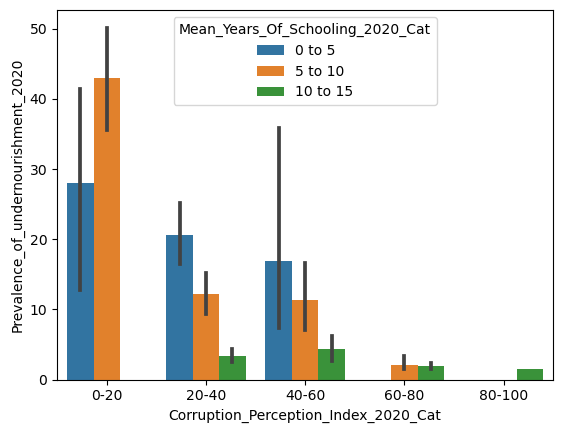

In [56]:
# Univariate Plot
# Hue == Access to Electricity
plot_transposed_df_univariate(df_in=df_combined_transposed_cat_cols, save_dest="Transposed/Hue_Access_To_Electricity",cols_dict=cols_dict, key="Access_To_Electricity",x="Prevalence_of_undernourishment")

# Bivariate Plots
# Corruption Index vs Prevalence
plot_transposed_df_bivariate_no_hue(df_in=df_combined_transposed_cat_cols, save_dest="Transposed/x_Corruption_Perception_Index",cols_dict=cols_dict, key="Corruption_Perception_Index", x="Prevalence_of_undernourishment")

# Mean Years of Schooling Cat vs Fertility Rate
plot_transposed_df_bivariate_no_hue(df_in=df_combined_transposed_cat_cols, save_dest="Transposed/x_Mean_Yrs_Schooling_y_Fertility_Rate",cols_dict=cols_dict, key="Mean_Years_Of_Schooling", x="Fertility_Rate")

# Sample plot
sns.barplot(data=df_combined_transposed_cat_cols, x="Corruption_Perception_Index_2020_Cat", y="Prevalence_of_undernourishment_2020", hue="Mean_Years_Of_Schooling_2020_Cat", order=["0-20", "20-40","40-60","60-80","80-100"])

**Insights**<br><br>
In general, the **lower** the *Corruption Perception Index*, the **higher** the *Prevalence of Undernourishment*.<br>
This reflects an **interesting insight** as one would expect that if a country is perceived as **less** *corrupt*, that means the law and order of the country is **well-maintained**, and the people would be **better off**.<br>
However, the data reflects the **opposite**<br><br>

If we go within each category of the Corruption Perception Index, it shows that the the countries with **higher** *Corruption Perception Index* have a **higher** *Mean Years of Schooling*. <br>
A few possible hypothesis could come from this:
1. In countries with **lower** *Mean Years of Schooling*, the *Corruption Perception Index* might not be reflective of the actual *Corruption level* since the people are not educated enough to perceive the *Corruption level*. 
2. **Higher** *educated* people are more likely to commit/have the ability to commit corrupted acts since the proportion of people of **higher** *education* backgrounds **increases** when the *Corruption Perception Index* **increases**.

## Preliminary model

In [130]:
def remove_outliers(df_in, df_out):
    mean, std = df_in.mean(), df_in.std()
    lower, upper = mean - 3 * std, mean + 3 * std  # type pd.Series
    out1 = df_in.index[(df_in < lower).any(axis=1)]
    out2 = df_in.index[(df_in > upper).any(axis=1)]
    # print(out1.union(out2))
    idxs = df_in.index.drop(out1.union(out2))
    df_in = df_in.loc[idxs].copy().reset_index(drop=True)
    df_out = df_out.loc[idxs].copy().reset_index(drop=True)
    return df_in, df_out

def normalize_z(dfin):
    df_new = (dfin - dfin.mean(axis=0)) / dfin.std(axis=0)
    return df_new

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names].copy()
    df_target = df[target_names].copy()
    return df_feature, df_target

def prepare_feature(df_feature):
    m = df_feature.shape[0]
    Xtmp = df_feature.to_numpy().reshape(m, len(df_feature.columns))
    X = np.concatenate((np.ones((m,1)), Xtmp), axis=1) # m * (n+1)
    return X

def prepare_target(df_target):
    m = df_target.shape[0]
    return df_target.to_numpy().reshape(m, 1)

def predict(df_feature, beta):
    df_feature_norm = normalize_z(df_feature)
    features = prepare_feature(df_feature_norm)
    yhat = calc_linear(features, beta)
    return yhat

def calc_linear(X, beta):
    return np.matmul(X, beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    total = df_feature.shape[0]
    n = int(test_size * total)
    
    np.random.seed(random_state)
    n_idxs = np.random.choice(total, n, replace=False)
    m_idxs = np.array([i for i in range(total) if i not in n_idxs])
    
    df_feature_train, df_target_train = df_feature.loc[m_idxs].copy(), df_target.loc[m_idxs].copy()
    df_feature_test, df_target_test = df_feature.loc[n_idxs].copy(), df_target.loc[n_idxs].copy()
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test


### Preprocessing
0. (null values already replaced with mean in loaded dataset)
1. Remove outliers (< or > 3*std)
2. Normalize features

In [131]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]
df_features, df_target = get_features_targets(df, feature_names, output_names)
n = len(df_features.columns)

print(df_features.columns)
print(df_features.shape, df_target.shape)


Index(['Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2020', 'CPI_Food_2020',
       'Net_FDI_2020', 'Infant_Mortality_Rate_2020', 'Unemployment_2020',
       'Access_To_Electricity_2020', 'Fertility_Rate_2020',
       'Immunization_Measles_2020', 'Labor_Force_Gender_Ratio_2020',
       'Corruption_Perception_Index_2020'],
      dtype='object')
(148, 11) (148, 1)


In [132]:
# Remove outliers
df_features, df_target = remove_outliers(df_features, df_target)
print("No. of outliers dropped:", df.shape[0] - df_features.shape[0])

No. of outliers dropped: 15


### Model training

In [133]:
def compute_cost(X, y, beta):
    m = X.shape[0]
    yhat = calc_linear(X, beta)
    J = (1 / 2 / m) * np.matmul((yhat - y).T, (yhat - y))
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        yhat = calc_linear(X, beta)
        first = X.T * alpha / m
        second = yhat - y
        beta = beta - np.matmul(first, second)
        cost = compute_cost(X, y, beta)
        J_storage.append(cost)
    return beta, J_storage

In [134]:
# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize the features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((n+1,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict(df_features_test, beta)

print(df_features_train.shape, df_features_test.shape)

(94, 11) (39, 11)


### Model evaluation

In [135]:
def r2_score(target, pred):
    SSres = np.sum((target - pred) ** 2)
    SStot = np.sum((target - np.mean(target)) ** 2)
    return 1 - SSres / SStot

def mean_squared_error(target, pred):
    return np.mean((target - pred) ** 2)

def mean_absolute_error(target, pred):
    return np.mean(np.abs(target - pred))

def adjusted_r2_score(target, pred, num_features):
    r2, n, p = r2_score(target, pred), target.shape[0], num_features
    return 1 - (1 - r2) * (n-1) / (n-p-1)

def mean_absolute_percentage_error(y, pred):
    return np.mean(np.abs(target - pred) / target)

In [136]:
# Evaluate the model 
target = prepare_target(df_target_test)

r2 = r2_score(target, pred)
adj_r2 = adjusted_r2_score(target, pred, n)
mse = mean_squared_error(target, pred)
mae = mean_absolute_error(target, pred)
mape = mean_absolute_percentage_error(target, pred)

print(r2)
print(adj_r2)
print(mse)
print(mae)
print(mape)


0.41061951578318223
0.17050154073188606
85.68979222809682
6.261088014014715
0.9421413373298412


=> Selected metrics for fine tuning: **Adjusted R2 score & MAE**
1. Adjusted R2 score measures how well the model approximates the dependent variable, explained by the data inputs using only independent variables that affect the dependent variable.
2. MAE measures the accuracy of a model using errors between observations that reflect the same phenomenon. The closer the MAE value is to 0, the more accurate the model is.  

## Fine tuning

### Feature selection
0. Generate different combinations of features
1. Test which combination performs the best
2. Determine a number of top features based on the best-performing 10 combinations
3. Calculate variance inflation factor (VIF) of the top features
4. Select optimal combination

In [137]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]

# Generate different combinations of features
from itertools import combinations
combis, r2s, maes, betas = [], {}, {}, {}
for i in range(3, len(feature_names)+1):
    combis += [list(x) for x in list(combinations(feature_names, i))]

# Test which combination performs the best
for combi in combis:
    df_features, df_target = get_features_targets(df, combi, output_names)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((n+1,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict() method
    pred = predict(df_features_test, beta)

    # Evaluate the model
    target = prepare_target(df_target_test)
    r2s[str(combi)] = adjusted_r2_score(target, pred, n)
    maes[str(combi)] = mean_absolute_error(target, pred)
    betas[str(combi)] = beta

# Sort all r2 scores from high to low
r2s = {k: v for k, v in sorted(r2s.items(), key=lambda item: item[1], reverse=True)}
for item in list(r2s.items())[:5]:
    print("\nFeatures:", item[0])
    print("Adjusted r2_score:", item[1])
    print("MAE:", maes[item[0]])



Features: ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.7026593368259044
MAE: 3.751501580481668

Features: ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.7012995098613872
MAE: 3.705827227637069

Features: ['Mean_Years_Of_Schooling_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6926202905466978
MAE: 3.779504068319886

Features: ['Life_Expectancy_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6919208351917403
MAE: 3.7671431958316117

Features: ['Mean_Years_Of_Schooling_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6883877651592659
MAE: 3.7551421241777385


In [138]:
# Determine top features
tmp1 = []
tmp = [item[0] for item in list(r2s.items())[:10]]
for x in tmp:
    tmp1 += x[1:-1].replace(' ', '').replace('\'', '').replace('\"', '').split(',') 
feature_names_top = np.unique(np.array(tmp1).flatten()).tolist()
feature_names_top

['Access_To_Electricity_2020',
 'Corruption_Perception_Index_2020',
 'Fertility_Rate_2020',
 'Life_Expectancy_2020',
 'Mean_Years_Of_Schooling_2020',
 'Net_FDI_2020']

In [139]:
# Write function for VIF
# Detect how correlated 1 feature is against the others
# 1 (not correlated), 1 - 5 (moderately correlated), > 5 (highly correlated)
def vif(response, explanatory):
    # Get features and targets
    df_features, df_target = get_features_targets(df, explanatory, response)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Normalize the features using z normalization
    df_features_z = normalize_z(df_features)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_z)
    target = prepare_target(df_target)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((n+1,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict() method for all data
    pred = predict(df_features, beta)

    # Evaluate the model
    r2 = r2_score(target, pred)
    vif = 1 / (1 - r2)
    return vif

In [140]:
import json, itertools

# Calculate VIF 
vifs = {}
for i, feature in enumerate(feature_names_top):
    vifs[feature] = vif([feature], feature_names_top[:i]+feature_names_top[i+1:])

# Sort all VIF scores from low to high
vifs = {k: v for k, v in sorted(vifs.items(), key=lambda item: item[1], reverse=False)}
vifs

{'Net_FDI_2020': 1.025015140534003,
 'Corruption_Perception_Index_2020': 2.451619003606814,
 'Mean_Years_Of_Schooling_2020': 2.929805224342769,
 'Access_To_Electricity_2020': 3.7691377491230154,
 'Fertility_Rate_2020': 4.436478466369317,
 'Life_Expectancy_2020': 5.501195798518766}

=> 'Drop 'Life_Expectancy_2020' which has a highly correlated VIF (> 5).

We selected **4 socio-economic indicators** corresponding to combination #2, which has the second-highest adjusted R2 score of 0.701 and lowest MAE of 3.705:
1. Net_FDI_2020
2. Access_To_Electricity_2020
3. Fertility_Rate_2020
4. Corruption_Perception_Index_2020

Text(0, 0.5, 'Prediction')

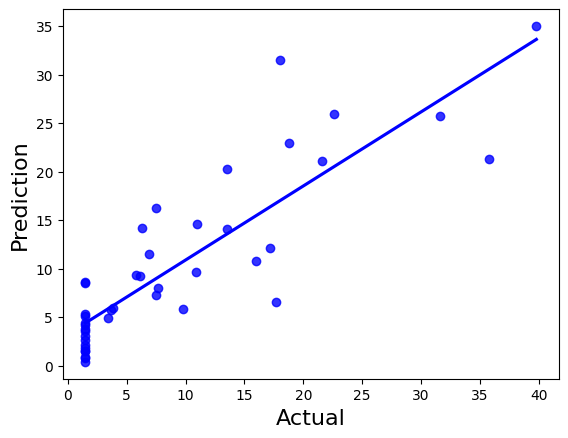

In [141]:
# Visualize performance of selected combination
selected_combi = ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
output_names = ['Prevalence_of_undernourishment_2020']

df_features, df_target = get_features_targets(df, selected_combi, output_names)
n = len(df_features.columns)
df_features, df_target = remove_outliers(df_features, df_target)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

target = prepare_target(df_target_test)
pred = predict(df_features_test, betas[str(selected_combi)])

myplot = sns.regplot(x=target,y=pred,ci=None,color='blue')
myplot.set_xlabel('Actual', fontsize=16)
myplot.set_ylabel('Prediction', fontsize=16)


### Variable transformation

1. Visualize distribution of dependent variable
2. Test different transformations of dependent variable
3. Visualization correlation of independent variable to dependent
3. Test different transformations of independent variables

**Visualization of dependent variable**

<AxesSubplot: ylabel='Density'>

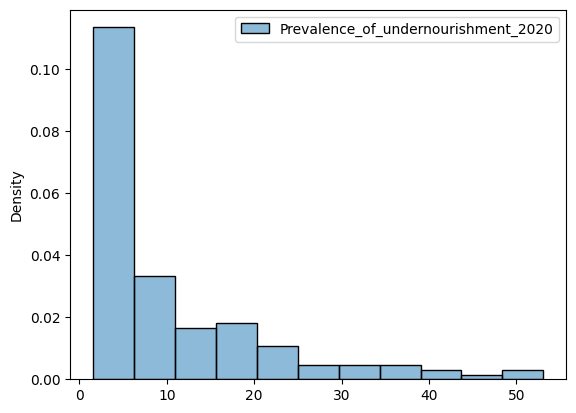

In [142]:
sns.histplot(df_target, stat="density")

**Transformation of dependent variable** <br>

We observed a **significant right skew** in the distribution of  'Prevalence_of_undernourishment'. To improve model performance, we tested 3 transformation functions:

1. Log transformation (np.log)
2. N-root transformation (np.sqrt, np.cbrt)
3. Reciprocal transformation (1 / values)

We performed min-max prior to all transformations to rescale our data into range [0, 1] while preserving the relationships among the original data values.

Our results showed that **reciprocal transformation** gives the best performance, **improving the adjusted R2 score from 0.70 to 0.73**. This conforms to reference [1] which suggests that reciprocal transformation is the most suitable for severely skewed data.

References: <br>
[1] [Transform Data to Normal Distribution in R](https://www.datanovia.com/en/lessons/transform-data-to-normal-distribution-in-r/) <br>
[2] [Linear Regression Models with Logarithmic Transformations](https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf) <br>
[3] [Feature Transformation for Multiple Linear Regression in Python](https://towardsdatascience.com/feature-transformation-for-multiple-linear-regression-in-python-8648ddf070b8) <br>
[4] [Methods to deal with zero values while performing log transformation of variable](https://discuss.analyticsvidhya.com/t/methods-to-deal-with-zero-values-while-performing-log-transformation-of-variable/2431)

<AxesSubplot: ylabel='Density'>

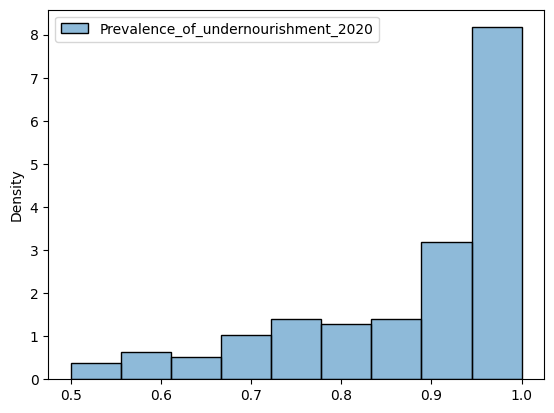

In [143]:
# Visualize distribution of data after selected transformation
# Min-max scaling 
df_target = (df_target - df_target.min()) / (df_target.max() - df_target.min())
# Reciprocal transformation
df_target = 1 / (df_target+1) # plus arbitrary constant to avoid zero division error
sns.histplot(df_target, stat="density")

0.7309203393366643


Text(0, 0.5, 'Prediction')

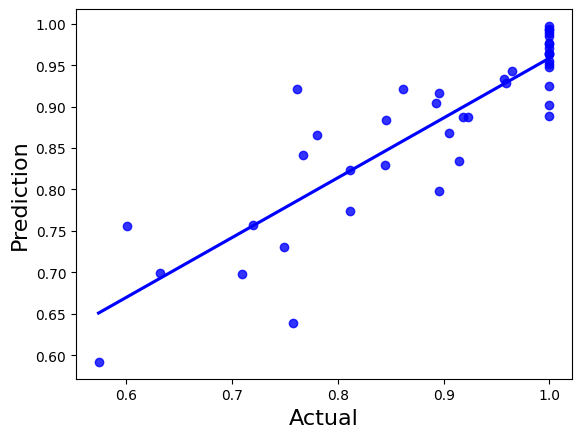

In [144]:
# Model performance after transforming the dependent variable
df_features, df_target = get_features_targets(df, selected_combi, output_names)
n = len(df_features.columns)
df_features, df_target = remove_outliers(df_features, df_target)

df_target = (df_target - df_target.min()) / (df_target.max() - df_target.min())
df_target = 1 / (df_target+1)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)
df_features_train_z = normalize_z(df_features_train)

X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((n+1,1))

beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)
pred = predict(df_features_test, beta)

# Evaluate the model 
target = prepare_target(df_target_test)
adj_r2 = adjusted_r2_score(target, pred, n)
print(adj_r2) # no MAE since data values for dependent variable have been disorted

myplot = sns.regplot(x=target,y=pred,ci=None,color='blue')
myplot.set_xlabel('Actual', fontsize=16)
myplot.set_ylabel('Prediction', fontsize=16)

**Visualization of independent variables**

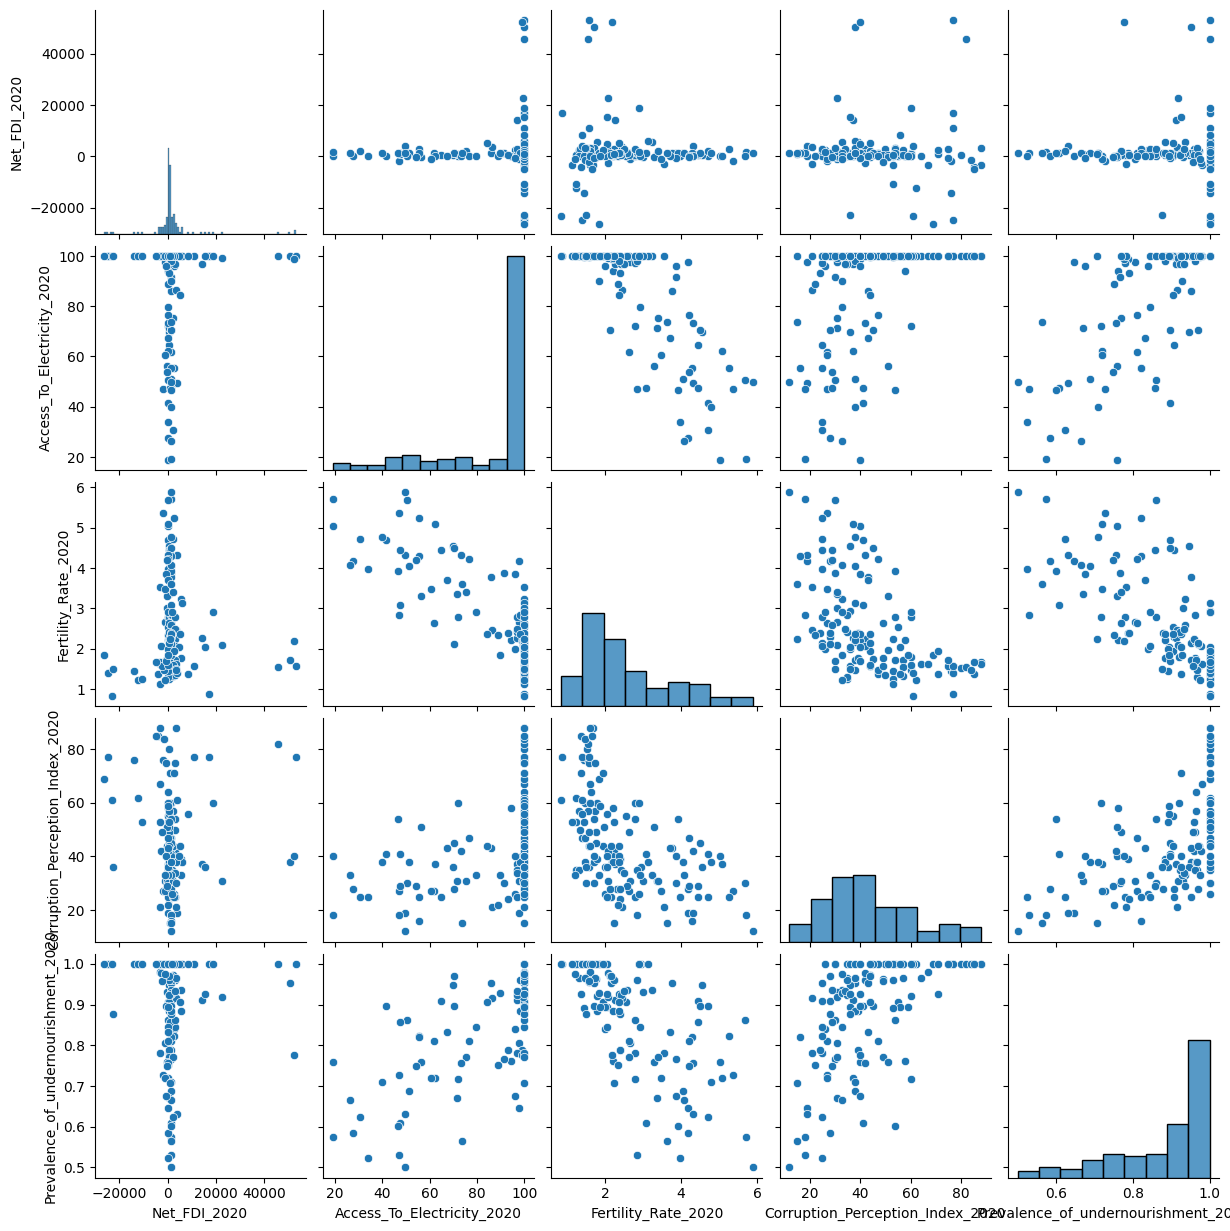

In [145]:
# Note that dependent variable has been transformed
sns.pairplot(data=pd.concat([df_features, df_target], axis=1)) 

**Transformation of independent variables** <br>

We observed that every independent variable can already be somewhat **linearly mapped** to the dependent variable. Nonetheless, we **tried out all possible transformations** on every variable below to see if we could discover any new insights:

1. Log transformation (np.log, np.log10)
3. N-root transformation (np.sqrt, np.cqrt)
5. Reciprocal transformation (1 / values)

We only applied min-max scaling for Net_FDI, which is the sole variable with negative data values.

Our results showed that there was **negligible improvement** in adjusted R2 score from 0.73 to 0.74, even in the best-performing transformation.

In [146]:
df_tmp = df[selected_combi].copy()
print("Negative values -----")
print((df_tmp < 0).sum())
print("\nZero values -------")
print((df_tmp == 0).sum())

Negative values -----
Net_FDI_2020                        34
Access_To_Electricity_2020           0
Fertility_Rate_2020                  0
Corruption_Perception_Index_2020     0
dtype: int64

Zero values -------
Net_FDI_2020                        0
Access_To_Electricity_2020          0
Fertility_Rate_2020                 0
Corruption_Perception_Index_2020    0
dtype: int64


In [153]:
# Tested out combinations of transformations for independent variables
from itertools import combinations, permutations

mms = lambda x: ((x - x.min()) / (x.max() - x.min()))
fs = [lambda x: np.log(x), lambda x: np.log10(x), \
    lambda x: x ** (1/2), lambda x: x ** (1/3), lambda x: 1 / x]
fs_str = ["lambda x: np.log(x)", "lambda x: np.log10(x)", \
    "lambda x: x ** (1/2)", "lambda x: x ** (1/3)", "lambda x: 1 / x"]
max_r2 = -1
c = []
for num_functions in [1]:
    fs_combis = list(combinations(fs, num_functions))
    feature_combis = list(permutations(selected_combi, num_functions))
    for fs_combi in fs_combis:
        for feature_combi in feature_combis:
            df_features, df_target = get_features_targets(df, selected_combi, output_names)
            n = len(df_features.columns)
            df_features, df_target = remove_outliers(df_features, df_target)
            for i in range(num_functions):
                if feature_combi[i] == "Net_FDI_2020": # perform min-max scaling if transforming Net_FDI_Flow
                    df_features[feature_combi[i]] = mms(df_features[feature_combi[i]]) + 1
                df_features[feature_combi[i]] = fs_combi[i](df_features[feature_combi[i]])
            
            df_target = (df_target - df_target.min()) / (df_target.max() - df_target.min())
            df_target = 1 / (df_target+1)

            # Split the data set into training and test
            df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

            # Normalize the features using z normalization
            df_features_train_z = normalize_z(df_features_train)

            # Change the features and the target to numpy array using the prepare functions
            X = prepare_feature(df_features_train_z)
            target = prepare_target(df_target_train)

            iterations = 1500
            alpha = 0.01
            beta = np.zeros((n+1,1))

            # Call the gradient_descent function
            beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

            # call the predict() method
            pred = predict(df_features_test, beta)

            # Evaluate the model 
            target = prepare_target(df_target_test)
            adj_r2 = adjusted_r2_score(target, pred, n)
            mae = mean_absolute_error(target, pred)
            if adj_r2 > max_r2:
                max_r2 = adj_r2
                c = {"Feature": feature_combi[0], \
                    "Transformation": fs_str[fs.index(fs_combi[0])]}
            # print(adj_r2)
            # print(mae)

print(max_r2)
print(c)

0.7409827811546835
{'Feature': 'Fertility_Rate_2020', 'Transformation': 'lambda x: np.log(x)'}
